<a href="https://colab.research.google.com/github/lucamerlini98/Plant_leave_recognizer-AMD_project/blob/main/algorithms_for_massive_data_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant leave recognizer

## 1 - Libraries and data loading

Import all useful libraries


In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
# File management and model saving
from google.colab import files
from google.colab import drive
import os
import shutil
import json
import sys

#data management and data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import metrics

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras import initializers
import keras_tuner

In [ ]:
drive.mount('/content/drive')

In [ ]:
!ls /content/drive/MyDrive/

For better code reusability and reproducibility, data is managed through the kaggle API. It allows you to automate and manage the loading within the code ensuring consistency across environments.


In [ ]:
# Active kaggle api
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move kaggle.json into a folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
# Use kaggle api to download the dataset
!kaggle datasets download "csafrit2/plant-leaves-for-image-classification"

100% 6.54G/6.56G [00:58<00:00, 37.9MB/s]
100% 6.56G/6.56G [00:58<00:00, 121MB/s] 


In [ ]:
# directory creation
! mkdir amd_project

In [ ]:
# Unzip dataset
!unzip plant-leaves-for-image-classification.zip -d amd_project

## 2 - Data exploration and organization

- Data is organized in 4 folders: "train", "valid", "test", "images to predict".
- The first 3 folders are organized into 22 subfolders, each containing images of a specific type of plant with its health status  



In [ ]:
# function to count all files in subdirectories
def count_files(dir_path):
    return len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])

def file_count_df(df_name, path):
    subfolders = os.listdir(path)
    data = []

    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        file_count = count_files(subfolder_path)
        data.append({'subfolder': subfolder, df_name + '_files': file_count})

    df = pd.DataFrame(data)

    globals()[df_name] = df

    return df

In [ ]:
# Creation of a summary dataframe on the images contained in each subdirectory
file_count_df('df_train', 'amd_project/Plants_2/train')
file_count_df('df_valid', 'amd_project/Plants_2/valid')
file_count_df('df_test', 'amd_project/Plants_2/test')

df_merged= df_train.merge(df_valid,on='subfolder').merge(df_test,on='subfolder')
df_merged

,subfolder,df_train_files,df_valid_files,df_test_files
0,Alstonia Scholaris diseased (P2a),244,5,5
1,Mango diseased (P0b),255,5,5
2,Chinar healthy (P11a),93,5,5
3,Jatropha diseased (P6b),114,5,5
4,Gauva diseased (P3b),131,5,5
5,Jamun diseased (P5b),335,5,5
6,Jamun healthy (P5a),268,5,5
7,Pomegranate diseased (P9b),261,5,5
8,Lemon healthy (P10a),149,5,5
9,Alstonia Scholaris healthy (P2b),168,5,5


In [ ]:
df_merged.sum()

subfolder         Alstonia Scholaris diseased (P2a)Mango disease...
df_train_files                                                 4274
df_valid_files                                                  110
df_test_files                                                   110
dtype: object

- From the dataframe above, the distribution of images in the train,validation, and test folders can be seen. It can be seen that the number of images in the validation dataset is very low (110 images, about 2.4% of the total).
- It is chosen to merge the training and validation folders and then to perform train-validation splits with a more balanced ratio.
- In addition, since the aim of the project is to predict the 12 plant species regardless of their health status, therefore subfolders with the same plant species are merged.

In [ ]:
#creation of a temporary folder
os.makedirs('amd_project/Plants_2/train_valid_tmp')

In [ ]:
# merge train and valid directories in the temporary folder
train_dir='amd_project/Plants_2/train'
valid_dir='amd_project/Plants_2/valid'
train_valid_dir='amd_project/Plants_2/train_valid_tmp'

for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    train_valid_subdir_path = os.path.join(train_valid_dir, subdir)

    os.makedirs(train_valid_subdir_path, exist_ok=True)

    for filename in os.listdir(subdir_path):
        src_path = os.path.join(subdir_path, filename)
        dest_path = os.path.join(train_valid_subdir_path, filename)
        shutil.move(src_path, dest_path)


for subdir in os.listdir(valid_dir):
    subdir_path = os.path.join(valid_dir, subdir)
    train_valid_subdir_path = os.path.join(train_valid_dir, subdir)

    for filename in os.listdir(subdir_path):
        src_path = os.path.join(subdir_path, filename)
        dest_path = os.path.join(train_valid_subdir_path, filename)
        shutil.move(src_path, dest_path)

In [ ]:
file_count_df('df_train_valid_tmp', 'amd_project/Plants_2/train_valid_tmp')

,subfolder,df_train_valid_tmp_files
0,Alstonia Scholaris diseased (P2a),249
1,Mango diseased (P0b),260
2,Chinar healthy (P11a),98
3,Jatropha diseased (P6b),119
4,Gauva diseased (P3b),136
5,Jamun diseased (P5b),340
6,Jamun healthy (P5a),273
7,Pomegranate diseased (P9b),266
8,Lemon healthy (P10a),154
9,Alstonia Scholaris healthy (P2b),173


In [ ]:
df_train_valid_tmp.sum()

subfolder                   Alstonia Scholaris diseased (P2a)Mango disease...
df_train_valid_tmp_files                                                 4384
dtype: object

In [ ]:
# Create a function to organize folders on plant species basis
def plant_species_organization(source_directory,dest_directory ):
  # Create the destination directory
  os.makedirs(dest_directory, exist_ok=True)

  subfolders=os.listdir(source_directory)

  # Create folders based on plant species
  for subfolder in subfolders:
      parts = subfolder.split(' ')
      plant_species = ' '.join(parts[:-2])
      subfolder_path = os.path.join(source_directory, subfolder)

      # Iterate through files in subfolder
      for file in os.listdir(subfolder_path):
          source_file_path = os.path.join(subfolder_path, file)
          destination_file_path = os.path.join(dest_directory, plant_species, file)

          # Create the plant species in destination directory
          os.makedirs(os.path.join(dest_directory, plant_species), exist_ok=True)

          # move the file to the destination directory
          shutil.move(source_file_path, destination_file_path)


In [ ]:
# Apply the function to train-valid folder
plant_species_organization('amd_project/Plants_2/train_valid_tmp','amd_project/Plants_2/train_valid' )

In [ ]:
file_count_df('df_train_valid', 'amd_project/Plants_2/train_valid')

,subfolder,df_train_valid_files
0,Arjun,442
1,Jamun,613
2,Bael,112
3,Alstonia Scholaris,422
4,Pongamia Pinnata,587
5,Pomegranate,548
6,Mango,424
7,Gauva,408
8,Basil,142
9,Lemon,226


In [ ]:
df_train_valid.sum()

subfolder               ArjunJamunBaelAlstonia ScholarisPongamia Pinna...
df_train_valid_files                                                 4384
dtype: object

In [ ]:
# Apply the function to test folder
plant_species_organization('amd_project/Plants_2/test','amd_project/Plants_2/test_new')

In [ ]:
file_count_df('df_test_new', 'amd_project/Plants_2/test_new')

,subfolder,df_test_new_files
0,Arjun,10
1,Jamun,10
2,Bael,5
3,Alstonia Scholaris,10
4,Pongamia Pinnata,10
5,Pomegranate,10
6,Mango,10
7,Gauva,10
8,Basil,5
9,Lemon,10


In [ ]:
# Identify the number of classes as a variable to make the code scalable.
# In this way in case of a larger dataset with more output classes the code is able to identify them
n_output_classes=len(os.listdir('amd_project/Plants_2/train_valid'))
n_output_classes

12

## 3 - Scalable environment

- The following code is designed to make the experiment scalable in the presence of a much larger dataset.
- It consents to achieve distributed training with data parallelism on multiple workers and multiple GPUs

In [ ]:
# The same seed is set for numpy, tensorflow, and python environments to make the experiment replicable
tf.keras.utils.set_random_seed(42)
# Uncomment the following line for fully replicability
# tf.config.experimental.enable_op_determinism()

In [ ]:
# Definition of a random initializer of weights using a HeNormal distribution
initializer=tf.keras.initializers.HeNormal(seed=42)

In [ ]:
# Define some macrovariables
NUM_WORKERS = 1

IMG_SIZE=(224, 224)
INPUT_SHAPE=(224, 224, 3)
INPUT_TENSOR=(None, 224, 224, 3)

BATCH_SIZE=128
GLOBAL_BATCH_SIZE=BATCH_SIZE*NUM_WORKERS

In [ ]:
# in case of more workers substitute tf_config['worker'] with the right workers address
# tf_config['task']['index']=0 if the worker is the chief worker and tf_config['task']['index']=1 for the other workers
if NUM_WORKERS > 1:
  tf_config = {
      'cluster': {
          'worker': ['localhost:11111', 'localhost:22222']
      },
      'task': {'type': 'worker', 'index': 0}
  }
  json.dumps(tf_config)
  os.environ['TF_CONFIG'] = json.dumps(tf_config)
  tf_config = json.loads(os.environ['TF_CONFIG'])

In [ ]:
# Define a strategy that allows to syncronized training across multiple machines with multiple GPUs
strategy = tf.distribute.MultiWorkerMirroredStrategy()

## 4 - Data preprocessing

In [ ]:
# create a data generator to rescale down between zero and one instead of 0 and 255 and to create validation split
train_valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# create a data generator to rescale down the values between zero and one instead of 0 and 255
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
# since images have three color channels, the color_mode is set to 'rgb'

# define directory
train_valid_dir= 'amd_project/Plants_2/train_valid'
test_dir= 'amd_project/Plants_2/test_new'

# Split the dataset into training and validation sets with size of validation set=0.2

train_ds = train_valid_generator.flow_from_directory(train_valid_dir, target_size=IMG_SIZE,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  batch_size=GLOBAL_BATCH_SIZE,
                                                  subset='training')

valid_ds = train_valid_generator.flow_from_directory(train_valid_dir, target_size=IMG_SIZE,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  batch_size=GLOBAL_BATCH_SIZE,
                                                  subset='validation')

test_ds = test_generator.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='categorical',
                                             color_mode='rgb',
                                             batch_size=GLOBAL_BATCH_SIZE,
                                             shuffle=False)


Found 3951 images belonging to 12 classes.
Found 433 images belonging to 12 classes.
Found 110 images belonging to 12 classes.


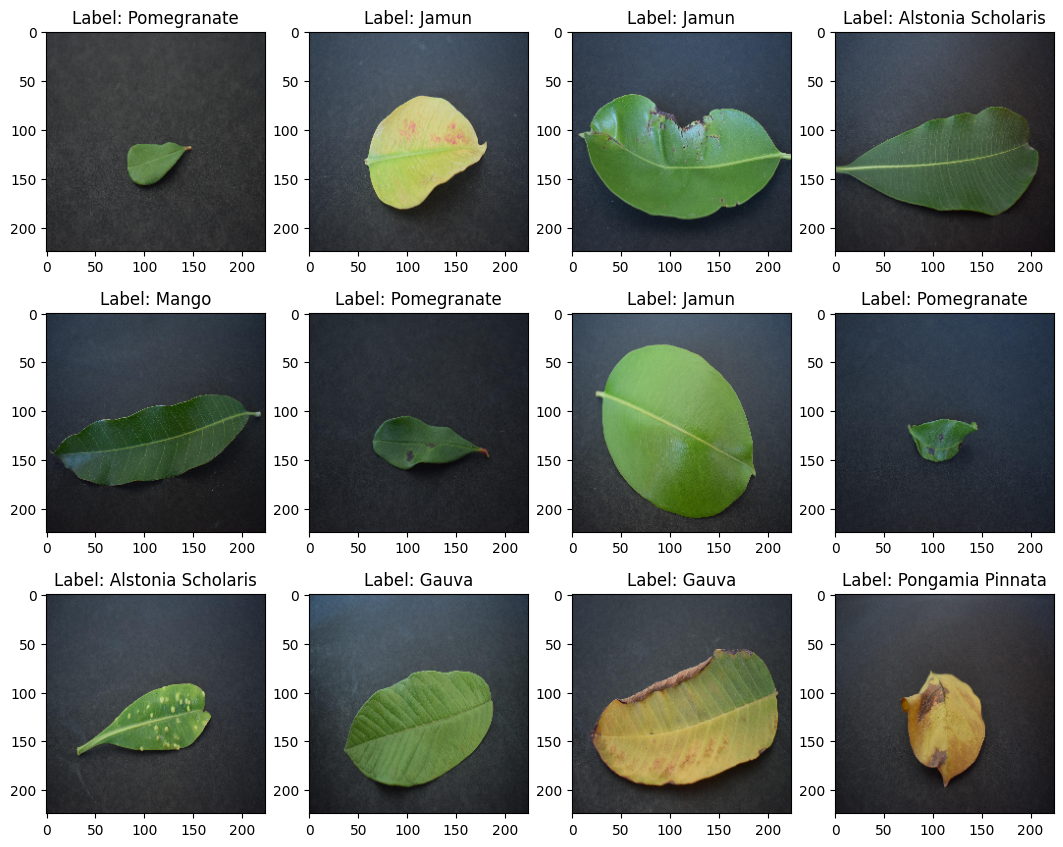

In [ ]:
class_labels = {v: k for k, v in train_ds.class_indices.items()}

# Plot a sample of 12 images from the training dataset with labels
plt.figure(figsize=[13, 14])
count = 1

for batch in train_ds:
    images, labels = batch
    for image, label in zip(images, labels):
        class_index = label.argmax()  # Get the class index from the one-hot encoded label
        class_label = class_labels[class_index]  # Map the class index to the class label
        plt.subplot(4, 4, count)
        plt.imshow(image)
        plt.title(f'Label: {class_label}')  # Display the class label as a title
        count += 1
        if count > 12:
            break
    if count > 12:
        break

plt.show()

- From the sample above it can be noted that the images through different classes seem to be very similar from each other and that images are all with a black background. Classes seem to be difficult to recognize, especially if the different types of leaves are not known   

In [ ]:
# Definition of early stopping callback to stop training if validation loss does not improve after 3 epochs
es = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', mode='min', verbose=1, patience = 3)

In [ ]:
# Definition of a function to plot the trend of training and validation accuracy and training and validation losses
def plot_history(cnn_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(cnn_history.history['loss'])
    plt.plot(cnn_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(cnn_history.history['acc'])
    plt.plot(cnn_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

## 5 - CNN model basic

In [ ]:
# Creation of a first simple model
# Compile the model with a CategoricalCrossentropy loss, configure the Adam optimizer with a learning rate of 0.001
with strategy.scope():
  model_basic = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dense(n_output_classes, activation='softmax')
  ])
  model_basic.build(input_shape=INPUT_TENSOR)
  model_basic.compile(loss='CategoricalCrossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
# Display a summary of the model architecture
model_basic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [ ]:
# train the model
history_model_basic = model_basic.fit(
        train_ds,
        epochs=15,
        verbose=1,
        callbacks = [es],
        validation_data=valid_ds
        )

Epoch 1/15
31/31 [==============================] - 579s 18s/step - loss: 2.5168 - acc: 0.1638 - val_loss: 2.3041 - val_acc: 0.3741
Epoch 2/15
31/31 [==============================] - 540s 17s/step - loss: 1.7192 - acc: 0.4325 - val_loss: 1.5980 - val_acc: 0.4503
Epoch 3/15
31/31 [==============================] - 570s 18s/step - loss: 1.2079 - acc: 0.5961 - val_loss: 1.2751 - val_acc: 0.5589
Epoch 4/15
31/31 [==============================] - 552s 18s/step - loss: 0.9353 - acc: 0.6917 - val_loss: 1.1404 - val_acc: 0.6582
Epoch 5/15
31/31 [==============================] - 577s 19s/step - loss: 0.7184 - acc: 0.7684 - val_loss: 0.9214 - val_acc: 0.6905
Epoch 6/15
31/31 [==============================] - 548s 18s/step - loss: 0.5824 - acc: 0.8102 - val_loss: 0.8168 - val_acc: 0.7506
Epoch 7/15
31/31 [==============================] - 561s 18s/step - loss: 0.4971 - acc: 0.8373 - val_loss: 0.7585 - val_acc: 0.7321
Epoch 8/15
31/31 [==============================] - 559s 18s/step - loss: 0.

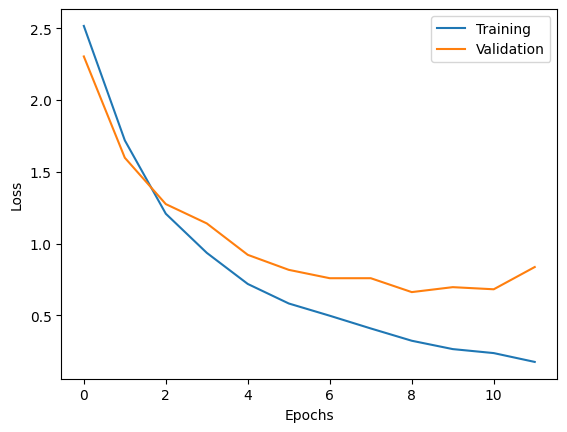

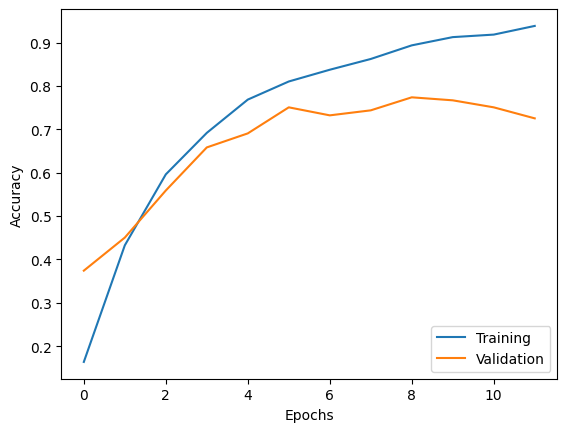

In [ ]:
# plot training and validation accuracy and training and validation losses
plot_history(history_model_basic)

In [ ]:
#save model
model_basic.save("/content/drive/MyDrive/model_basic.h5")
model_basic.save_weights("/content/drive/MyDrive/model_basic_weights.h5")

# files.download('model_basic.h5')
# files.download('model_basic_weights.h5')
# model_basic = keras.models.load_model("/content/drive/MyDrive/model_basic.h5")
# model_basic.load_weights('/content/drive/MyDrive/model_basic_weights.h5')

## 6 - CNN model with dropout

In [ ]:
# Creation of a model with dropout to reduce overfitting
# Compile the model with a CategoricalCrossentropy loss, configure the Adam optimizer with a learning rate of 0.001
with strategy.scope():
  model_dropout = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_output_classes, activation='softmax')
  ])

  model_dropout.build(input_shape=INPUT_TENSOR)
  model_dropout.compile(loss='CategoricalCrossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['acc'])


In [ ]:
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)       

In [ ]:
# train the model
history_model_dropout = model_dropout.fit(
        train_ds,
        epochs=15,
        verbose=1,
        callbacks = [es],
        validation_data=valid_ds
        )

Epoch 1/15
31/31 [==============================] - 596s 19s/step - loss: 2.3395 - acc: 0.1574 - val_loss: 2.3842 - val_acc: 0.2079
Epoch 2/15
31/31 [==============================] - 567s 18s/step - loss: 1.8373 - acc: 0.3693 - val_loss: 1.9413 - val_acc: 0.3095
Epoch 3/15
31/31 [==============================] - 541s 18s/step - loss: 1.3763 - acc: 0.5158 - val_loss: 1.8663 - val_acc: 0.3256
Epoch 4/15
31/31 [==============================] - 582s 19s/step - loss: 1.1846 - acc: 0.5872 - val_loss: 1.4839 - val_acc: 0.4781
Epoch 5/15
31/31 [==============================] - 531s 17s/step - loss: 0.9906 - acc: 0.6525 - val_loss: 1.1912 - val_acc: 0.6051
Epoch 6/15
31/31 [==============================] - 580s 19s/step - loss: 0.8545 - acc: 0.7021 - val_loss: 1.2815 - val_acc: 0.6189
Epoch 7/15
31/31 [==============================] - 574s 19s/step - loss: 0.7296 - acc: 0.7542 - val_loss: 1.0398 - val_acc: 0.6605
Epoch 8/15
31/31 [==============================] - 609s 20s/step - loss: 0.

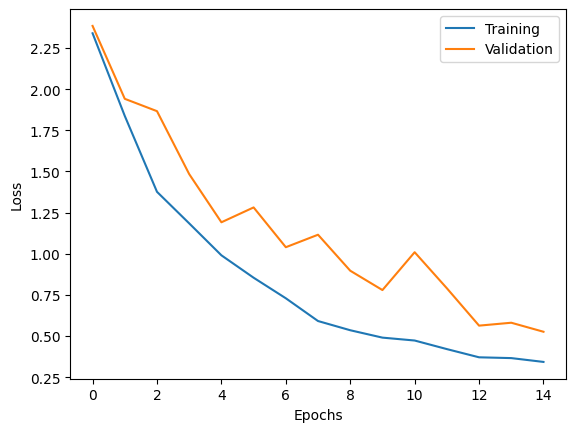

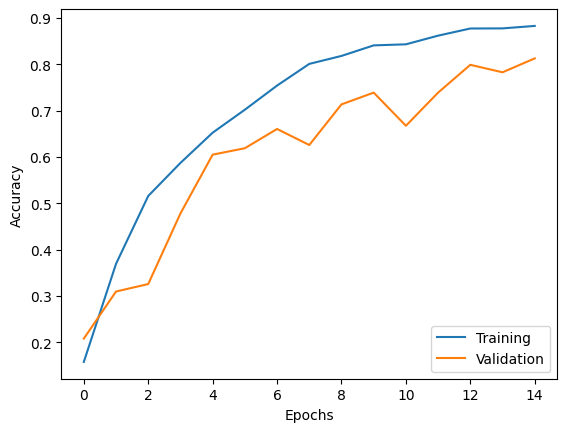

In [ ]:
# plot training and validation accuracy and training and validation losses
plot_history(history_model_dropout)

In [ ]:
#save model
model_dropout.save("/content/drive/MyDrive/model_dropout.h5")
model_dropout.save_weights("/content/drive/MyDrive/model_dropout_weights.h5")

# files.download('model_dropout.h5')
# files.download('model_dropout_weights.h5')
# model_dropout = keras.models.load_model("/content/drive/MyDrive/model_dropout.h5")
# model_dropout.load_weights('/content/drive/MyDrive/model_dropout_weights.h5')

## 7 - CNN with dropout and data augmentation

In [ ]:
# Creation of a model with dropout and data augmentation to improve performance and reduce overfitting
# Compile the model with a CategoricalCrossentropy loss, configure the Adam optimizer with a learning rate of 0.001
with strategy.scope():
  model_mixed = tf.keras.models.Sequential([
    # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    # tf.keras.layers.RandomContrast(0.8, 1.2),
    # tf.keras.layers.RandomZoom(0.1),
    # tf.keras.layers.RandomTranslation(0.1, 0.1),

    tf.keras.layers.Conv2D(16, (3,3), input_shape=INPUT_SHAPE, kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(32, (3,3), kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(32, (3,3), kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(16, (3,3), kernel_initializer=initializer),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(n_output_classes, activation='softmax')
  ])

  model_mixed.build(input_shape=INPUT_TENSOR)
  model_mixed.compile(loss='CategoricalCrossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['acc'])

In [ ]:
model_mixed.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 111, 111, 16)      0         
                                                                 
 activation (Activation)     (None, 111, 111, 16)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)     

In [ ]:
# train the model
history_model_mixed = model_mixed.fit(
        train_ds,
        epochs=15,
        verbose=1,
        callbacks = [es],
        validation_data=valid_ds
        )

Epoch 1/15
31/31 [==============================] - 645s 20s/step - loss: 3.0156 - acc: 0.1759 - val_loss: 2.0017 - val_acc: 0.3372
Epoch 2/15
31/31 [==============================] - 620s 20s/step - loss: 1.5927 - acc: 0.4946 - val_loss: 1.2344 - val_acc: 0.6651
Epoch 3/15
31/31 [==============================] - 602s 19s/step - loss: 0.9664 - acc: 0.7016 - val_loss: 0.8750 - val_acc: 0.7252
Epoch 4/15
31/31 [==============================] - 643s 21s/step - loss: 0.6715 - acc: 0.7973 - val_loss: 0.7410 - val_acc: 0.7413
Epoch 5/15
31/31 [==============================] - 627s 20s/step - loss: 0.4739 - acc: 0.8686 - val_loss: 0.5983 - val_acc: 0.8106
Epoch 6/15
31/31 [==============================] - 578s 19s/step - loss: 0.3678 - acc: 0.8975 - val_loss: 0.4671 - val_acc: 0.8453
Epoch 7/15
31/31 [==============================] - 584s 19s/step - loss: 0.3057 - acc: 0.9119 - val_loss: 0.5153 - val_acc: 0.8222
Epoch 8/15
31/31 [==============================] - 582s 19s/step - loss: 0.

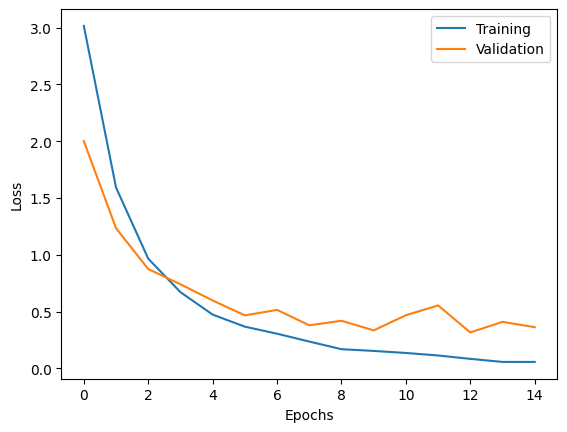

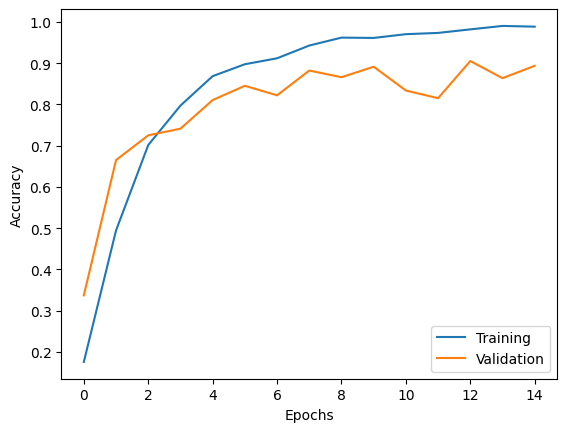

In [ ]:
# plot training and validation accuracy and training and validation losses
plot_history(history_model_mixed)

In [ ]:
#save model
model_mixed.save("/content/drive/MyDrive/model_mixed.h5")
model_mixed.save_weights("/content/drive/MyDrive/model_mixed_weights.h5")

# files.download('model_mixed.h5')
# files.download('model_mixed_weights.h5')
# model_mixed = keras.models.load_model("/content/drive/MyDrive/model_mixed.h5")
# model_mixed.load_weights('/content/drive/MyDrive/model_mixed_weights.h5')

## 8 - Hyperparameter tuning

In [ ]:
#Definition of parameters to be optimized
def tune_model(hp):

    conv_dropout = hp.Float("conv_dropout", min_value = 0.05, max_value = 0.3, step = 0.05)
    nn_dropout = hp.Float("nn_dropout", min_value = 0.1, max_value = 0.4, step = 0.1)

    conv_filters1=hp.Choice('conv_filters1', [128, 64, 32, 16])
    conv_filters2=hp.Choice('conv_filters2', [128, 64, 32, 16])
    conv_filters3=hp.Choice('conv_filters3', [128, 64, 32, 16])
    conv_filters4=hp.Choice('conv_filters4', [128, 64, 32, 16])
    conv_filters5=hp.Choice('conv_filters5', [128, 64, 32, 16])

    dense_units_1=hp.Choice('dense_units_1', [1024, 512, 256, 128])
    dense_units_2=hp.Choice('dense_units_2', [128, 64, 32])

    lrate= hp.Float("lrate", min_value = 0.0005, max_value = 0.0015, step = 0.0005)

    model_hp =  tf.keras.models.Sequential([
    # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    #tf.keras.layers.RandomContrast(0.8, 1.2),
    # tf.keras.layers.RandomZoom(0.2),
    # tf.keras.layers.RandomTranslation(0.1, 0.1),

    tf.keras.layers.Conv2D(filters=conv_filters1, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(conv_dropout),

    tf.keras.layers.Conv2D(filters =conv_filters2, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(conv_dropout),

    tf.keras.layers.Conv2D(filters =conv_filters3, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(conv_dropout),

    tf.keras.layers.Conv2D(filters =conv_filters4, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(conv_dropout),

    tf.keras.layers.Conv2D(filters =conv_filters5, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(conv_dropout),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dense_units_1, activation='relu'),
    tf.keras.layers.Dropout(nn_dropout),
    tf.keras.layers.Dense(units=dense_units_2, activation='relu'),
    tf.keras.layers.Dropout(nn_dropout),
    tf.keras.layers.Dense(n_output_classes, activation='softmax')
    ])


    model_hp.compile(loss='CategoricalCrossentropy',
                optimizer=Adam(learning_rate=lrate),
                metrics=['acc'])

    return model_hp

In [ ]:
hp_tuner = keras_tuner.BayesianOptimization(
    tune_model,
    objective='val_loss',
    max_trials=10)

In [ ]:
hp_tuner.search(train_ds, epochs=10, callbacks = [es],  validation_data=valid_ds)

Trial 10 Complete [04h 18m 54s]
val_loss: 0.7972844839096069

Best val_loss So Far: 0.737058699131012
Total elapsed time: 1d 07h 15m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hp_model = hp_tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hp_model.values

{'conv_dropout': 0.05,
 'nn_dropout': 0.1,
 'conv_filters1': 128,
 'conv_filters2': 128,
 'conv_filters3': 64,
 'conv_filters4': 128,
 'conv_filters5': 64,
 'dense_units_1': 1024,
 'dense_units_2': 64,
 'lrate': 0.0005}

In [ ]:
with strategy.scope():
  tuned_model =  tf.keras.models.Sequential([

    #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.05),

    tf.keras.layers.Conv2D(filters =128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.05),

    tf.keras.layers.Conv2D(filters =64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.05),

    tf.keras.layers.Conv2D(filters =128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.05),

    tf.keras.layers.Conv2D(filters =64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.05),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(n_output_classes, activation='softmax')
  ])

  tuned_model.build(input_shape=INPUT_TENSOR)
  tuned_model.compile(loss='CategoricalCrossentropy',
                  optimizer=Adam(learning_rate=0.0005),
                  metrics=['acc'])

In [ ]:
# tuned_model = hp_tuner.hypermodel.build(best_hp_model)
history_tuned_model = tuned_model.fit(train_ds,
                         epochs = 15,
                         callbacks=[es],
                         validation_data = valid_ds)

Epoch 1/15
31/31 [==============================] - 675s 21s/step - loss: 2.3411 - acc: 0.1471 - val_loss: 2.2685 - val_acc: 0.3303
Epoch 2/15
31/31 [==============================] - 613s 20s/step - loss: 1.8841 - acc: 0.3419 - val_loss: 1.5487 - val_acc: 0.4988
Epoch 3/15
31/31 [==============================] - 593s 19s/step - loss: 1.4000 - acc: 0.5103 - val_loss: 1.1220 - val_acc: 0.6351
Epoch 4/15
31/31 [==============================] - 604s 20s/step - loss: 1.1441 - acc: 0.5986 - val_loss: 1.0842 - val_acc: 0.6074
Epoch 5/15
31/31 [==============================] - 591s 19s/step - loss: 1.0019 - acc: 0.6568 - val_loss: 0.9469 - val_acc: 0.6628
Epoch 6/15
31/31 [==============================] - 613s 20s/step - loss: 0.8952 - acc: 0.6965 - val_loss: 0.9368 - val_acc: 0.7067
Epoch 7/15
31/31 [==============================] - 628s 20s/step - loss: 0.7775 - acc: 0.7373 - val_loss: 0.8355 - val_acc: 0.7367
Epoch 8/15
31/31 [==============================] - 619s 20s/step - loss: 0.

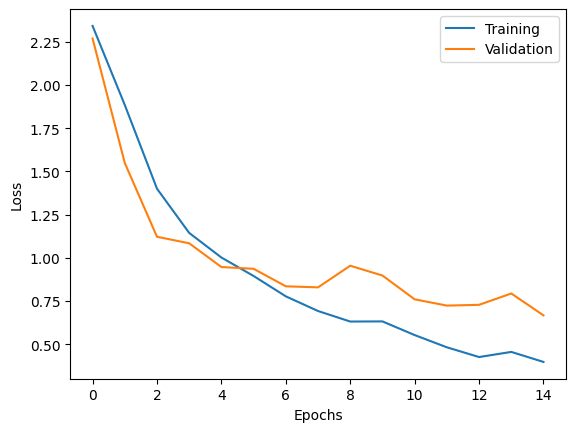

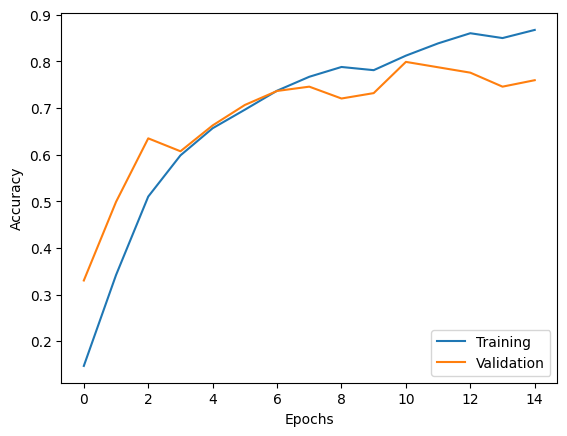

In [ ]:
# plot training and validation accuracy and training and validation losses
plot_history(history_tuned_model)

In [ ]:
# Save model
tuned_model.save("/content/drive/MyDrive/tuned_model.h5")
tuned_model.save_weights("/content/drive/MyDrive/tuned_model_weights.h5")

# files.download('tuned_model.h5')
# files.download('tuned_model_weights.h5')
# tuned_model = keras.models.load_model("/content/drive/MyDrive/tuned_model.h5")
# tuned_model.load_weights('/content/drive/MyDrive/tuned_model_weights.h5')

- Unfortunately, due to the limited number of attempts resulting from high time and computational costs, hyperparameter tuning did not yield significant improvements in the performance of the previous network. Consequently, a new approach was pursued: transfer learning.

## 9 - Transfer learning

### ResNet50

In [ ]:
resnet_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, validation_split=0.1)
resnet_generator_test=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
INPUT_SHAPE_RES=(224, 224, 3)
IMG_SIZE_RES=(224, 224)

In [ ]:
# Split the dataset into training and validation sets with size of validation set=0.1

train_res_ds = resnet_generator.flow_from_directory(train_valid_dir, target_size=IMG_SIZE_RES,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  batch_size=GLOBAL_BATCH_SIZE,
                                                  subset='training')

valid_res_ds = resnet_generator.flow_from_directory(train_valid_dir, target_size=IMG_SIZE_RES,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  batch_size=GLOBAL_BATCH_SIZE,
                                                  subset='validation')

test_res_ds = resnet_generator_test.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='categorical',
                                             color_mode='rgb',
                                             batch_size=GLOBAL_BATCH_SIZE,
                                             shuffle=False)



Found 3951 images belonging to 12 classes.
Found 433 images belonging to 12 classes.
Found 110 images belonging to 12 classes.


In [ ]:
pretrained_model_resnet=tf.keras.applications.ResNet50(include_top=False,
                                                input_shape=INPUT_SHAPE_RES,
                                                pooling='avg', classes=n_output_classes,
                                                weights='imagenet')
for layer in pretrained_model_resnet.layers:
  layer.trainable=False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
pretrained_model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
input_resnet = keras.Input(shape=INPUT_SHAPE_RES)
x = input_resnet

x = pretrained_model_resnet(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
output_resnet = tf.keras.layers.Dense(n_output_classes, activation='softmax')(x)

In [ ]:
model_resnet = tf.keras.Model(inputs=input_resnet, outputs=output_resnet)

model_resnet.compile(loss='CategoricalCrossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
# train the model
history_model_resnet = model_resnet.fit(
        train_res_ds,
        epochs=15,
        verbose=1,
        callbacks = [es],
        validation_data=valid_res_ds
        )

Epoch 1/15
31/31 [==============================] - 1317s 42s/step - loss: 1.1798 - acc: 0.7302 - val_loss: 0.3241 - val_acc: 0.9169
Epoch 2/15
31/31 [==============================] - 1272s 41s/step - loss: 0.1604 - acc: 0.9496 - val_loss: 0.1716 - val_acc: 0.9446
Epoch 3/15
31/31 [==============================] - 1278s 41s/step - loss: 0.0740 - acc: 0.9790 - val_loss: 0.1465 - val_acc: 0.9538
Epoch 4/15
31/31 [==============================] - 1282s 41s/step - loss: 0.0503 - acc: 0.9879 - val_loss: 0.1189 - val_acc: 0.9630
Epoch 5/15
31/31 [==============================] - 1300s 42s/step - loss: 0.0300 - acc: 0.9944 - val_loss: 0.1085 - val_acc: 0.9677
Epoch 6/15
31/31 [==============================] - 1286s 42s/step - loss: 0.0214 - acc: 0.9970 - val_loss: 0.1132 - val_acc: 0.9630
Epoch 7/15
31/31 [==============================] - 1246s 40s/step - loss: 0.0197 - acc: 0.9965 - val_loss: 0.0903 - val_acc: 0.9769
Epoch 8/15
31/31 [==============================] - 1256s 41s/step - 

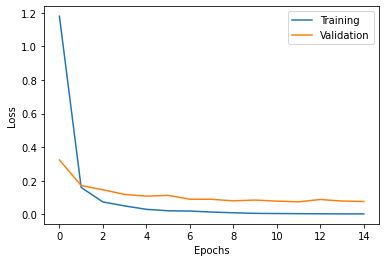

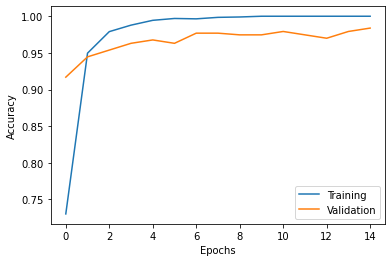

In [ ]:
plot_history(history_model_resnet)

In [ ]:
# Save model
model_resnet.save("/content/drive/MyDrive/model_resnet.h5")
model_resnet.save_weights("/content/drive/MyDrive/model_resnet_weights.h5")

# files.download('model_resnet.h5')
# files.download('resnet_weights.h5')
# model_resnet = keras.models.load_model("/content/drive/MyDrive/model_resnet.h5")
# model_resnet.load_weights('/content/drive/MyDrive/model_resnet_weights.h5')

### DenseNet121


In [ ]:
densenet_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input, validation_split=0.1)
densenet_generator_test = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [ ]:
INPUT_SHAPE_DENSENET=(224, 224, 3)
IMG_SIZE_DENSENET=(224, 224)

In [ ]:
# Split the dataset into training and validation sets with size of validation set=0.1

train_densenet_ds = densenet_generator.flow_from_directory(train_valid_dir, target_size=IMG_SIZE_DENSENET,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  batch_size=GLOBAL_BATCH_SIZE,
                                                  subset='training')

valid_densenet_ds = densenet_generator.flow_from_directory(train_valid_dir, target_size=IMG_SIZE_DENSENET,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  batch_size=GLOBAL_BATCH_SIZE,
                                                  subset='validation')

test_densenet_ds = densenet_generator_test.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='categorical',
                                             color_mode='rgb',
                                             batch_size=GLOBAL_BATCH_SIZE,
                                             shuffle=False)




Found 3951 images belonging to 12 classes.
Found 433 images belonging to 12 classes.
Found 110 images belonging to 12 classes.


In [ ]:
pretrained_model_densenet=tf.keras.applications.DenseNet121(include_top=False,
                                                input_shape=INPUT_SHAPE_DENSENET,
                                                pooling='avg', classes=n_output_classes,
                                                weights='imagenet')
for layer in pretrained_model_densenet.layers:
  layer.trainable=False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
pretrained_model_densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [ ]:
input_densenet = keras.Input(shape=INPUT_SHAPE_DENSENET)
x = input_densenet
x = pretrained_model_densenet(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output_densenet = tf.keras.layers.Dense(n_output_classes, activation='softmax')(x)

In [ ]:
model_densenet = tf.keras.Model(inputs=input_densenet, outputs=output_densenet)

model_densenet.compile(loss='CategoricalCrossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
# train the model
history_model_densenet = model_densenet.fit(
        train_densenet_ds,
        epochs=15,
        verbose=1,
        callbacks = [es],
        validation_data=valid_densenet_ds
        )

Epoch 1/15
31/31 [==============================] - 599s 19s/step - loss: 1.0121 - acc: 0.7170 - val_loss: 0.4094 - val_acc: 0.9053
Epoch 2/15
31/31 [==============================] - 579s 19s/step - loss: 0.2458 - acc: 0.9393 - val_loss: 0.2257 - val_acc: 0.9469
Epoch 3/15
31/31 [==============================] - 547s 18s/step - loss: 0.1442 - acc: 0.9661 - val_loss: 0.1833 - val_acc: 0.9538
Epoch 4/15
31/31 [==============================] - 624s 20s/step - loss: 0.1085 - acc: 0.9754 - val_loss: 0.1823 - val_acc: 0.9423
Epoch 5/15
31/31 [==============================] - 579s 19s/step - loss: 0.0825 - acc: 0.9841 - val_loss: 0.1364 - val_acc: 0.9677
Epoch 6/15
31/31 [==============================] - 588s 19s/step - loss: 0.0635 - acc: 0.9894 - val_loss: 0.1259 - val_acc: 0.9607
Epoch 7/15
31/31 [==============================] - 544s 18s/step - loss: 0.0502 - acc: 0.9932 - val_loss: 0.1432 - val_acc: 0.9538
Epoch 8/15
31/31 [==============================] - 599s 19s/step - loss: 0.

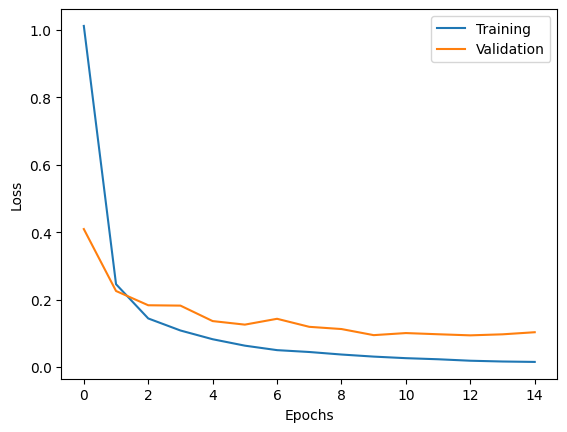

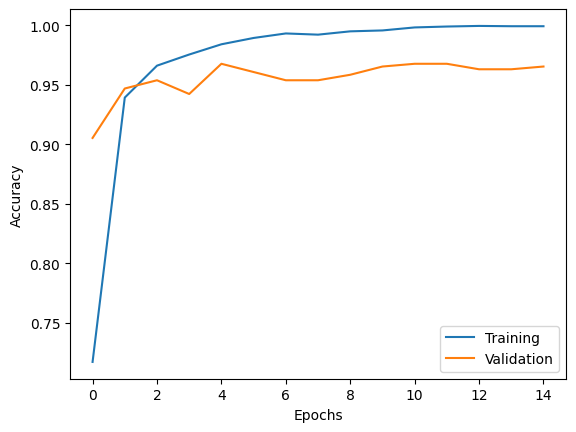

In [ ]:
# plot training and validation accuracy and training and validation losses
plot_history(history_model_densenet)

In [ ]:
# Save model
model_densenet.save("/content/drive/MyDrive/model_densenet.h5")
model_densenet.save_weights("/content/drive/MyDrive/model_densenet_weights.h5")

# files.download('model_densenet.h5')
# files.download('model_densenet_weights.h5')
# model_densenet = keras.models.load_model("/content/drive/MyDrive/model_densenet.h5")
# model_densenet.load_weights('/content/drive/MyDrive/model_densenet_weights.h5')

##  10 - Predictions on test set

In [ ]:
# Evaluate the best model found on the unseen test set
loss_test, accuracy_test = model_resnet.evaluate(test_res_ds)
print('Test loss:', loss_test)
print('Test accuracy:', accuracy_test)

1/1 [==============================] - 47s 47s/step - loss: 0.0312 - acc: 0.9909
Test loss: 0.031157054007053375
Test accuracy: 0.9909090995788574


In [ ]:
predictions = model_resnet.predict(test_res_ds)

1/1 [==============================] - 34s 34s/step


In [ ]:
# Get true labels and class labels
y_true = test_res_ds.classes
class_labels = list(test_res_ds.class_indices.keys())

# Predict probabilities for the test dataset
y_pred_probs = model_resnet.predict(test_res_ds)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
predicted_labels = [class_labels[i] for i in y_pred]


1/1 [==============================] - 32s 32s/step


In [ ]:
report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report)

                    precision    recall  f1-score   support

Alstonia Scholaris       1.00      1.00      1.00        10
             Arjun       1.00      1.00      1.00        10
              Bael       1.00      1.00      1.00         5
             Basil       1.00      1.00      1.00         5
            Chinar       1.00      1.00      1.00        10
             Gauva       1.00      0.90      0.95        10
             Jamun       0.91      1.00      0.95        10
          Jatropha       1.00      1.00      1.00        10
             Lemon       1.00      1.00      1.00        10
             Mango       1.00      1.00      1.00        10
       Pomegranate       1.00      1.00      1.00        10
  Pongamia Pinnata       1.00      1.00      1.00        10

          accuracy                           0.99       110
         macro avg       0.99      0.99      0.99       110
      weighted avg       0.99      0.99      0.99       110



In [ ]:
image_paths = test_res_ds.filepaths

# Class labels from the data generator
class_labels = list(test_res_ds.class_indices.keys())

# Map numerical labels to class labels
y_pred_labels = [class_labels[i] for i in y_pred]
y_true_labels = [class_labels[i] for i in y_true]

data_true_pred = {
    'Predicted Label': y_pred_labels,
    'True Label': y_true_labels,
    'Image Path': image_paths
}

df_true_pred = pd.DataFrame(data_true_pred)

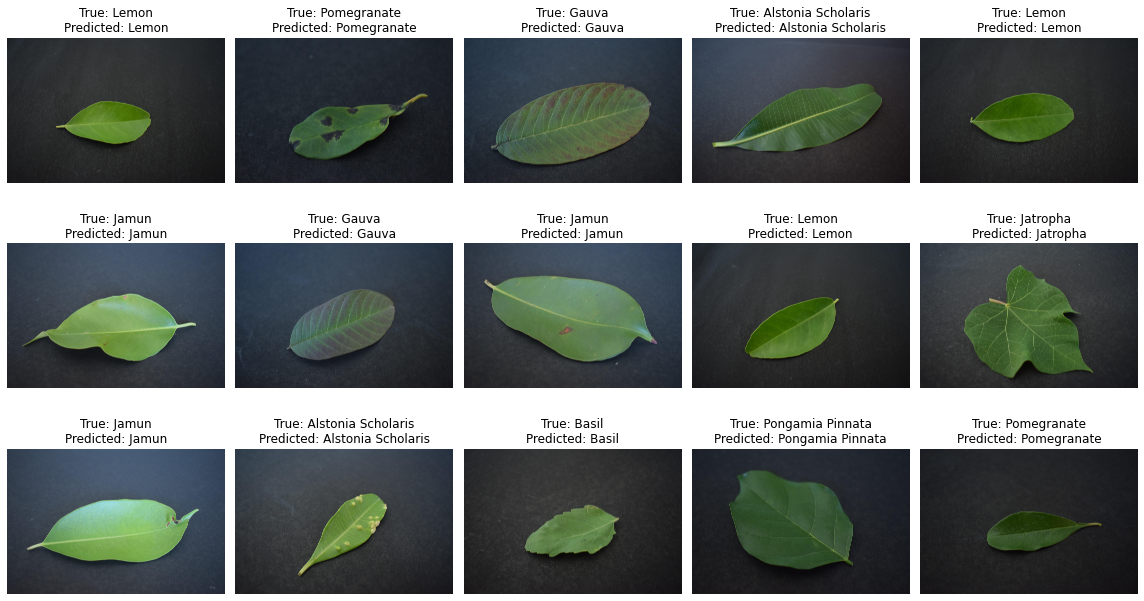

In [ ]:
# Display a random samples of images with true and predicted labels

random_samples = df_true_pred.sample(n=15)

fig, axes = plt.subplots(3, 5, figsize=(16, 9))
axes = axes.flatten()

for i, (_, row) in enumerate(random_samples.iterrows()):
    image_path = row['Image Path']
    true_label = row['True Label']
    predicted_label = row['Predicted Label']

    image = plt.imread(image_path)

    axes[i].imshow(image)
    axes[i].axis('off')

    title = f'True: {true_label}\nPredicted: {predicted_label}'
    axes[i].set_title(title)

plt.tight_layout()
plt.show()